In [1]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Controlled state preparation using rotations

In [2]:
from qualtran.bloqs.controlled_state_preparation import ControlledStatePreparationUsingRotations
from qualtran.drawing import show_bloq
from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import ZeroState, OneState, OneEffect
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientState
import numpy as np
from random import uniform

/home/anon/universidad/Qualtran/venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


from qualtran.bloqs.controlled_state_preparation import ControlledStatePreparationUsingRotations
from qualtran.drawing import show_bloq
from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import ZeroState, OneState, OneEffect
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientState
import numpy as np
from random import uniform

This bloq prepares a state $|u>$ given a list of its coefficients controlled by another qubit. It uses phase kickback on a gradient state register to perform the rotations, so such state must be provided. It can be obtained from `PhaseGradientState`.

Refer to https://arxiv.org/abs/1812.00954 page 3 for more details on state preparation using rotations.

## Example of use

Assume one wants to implement an arbitrary state whose coefficients are stored in `state_coefs` with `n_qubits` sites using a resolution for the rotations of `rot_reg_size` qubits.

In [3]:
def genRandomState (sites):
  state = [uniform(-1,1) + uniform(-1,1)*1j for _ in range(2**sites)]
  norm = np.sqrt(sum([abs(s)**2 for s in state]))
  return [s/norm for s in state]

rot_reg_size = 4
n_qubits = 3
state_coefs = genRandomState(n_qubits)

## Building the bloq

The parameters that the bloq receives are:

  - `n_qubits`: number of qubits that the state to be encoded takes.
  - `rot_reg_size`: number of qubits used to store the rotation angle. This determines the accuracy of the results, but increases computational resources.
  - `state`: tuple that contains the coefficients of the quantum state to be encoded.

Below the bloq and its decomposition are shown. It is possible to see three big bloqs that do the sequential rotations to prepare the amplitude of each qubit and a final bloq to encode the phases of the state.

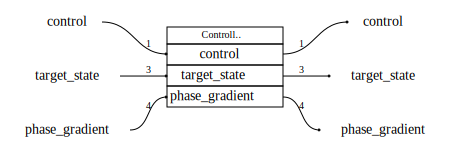

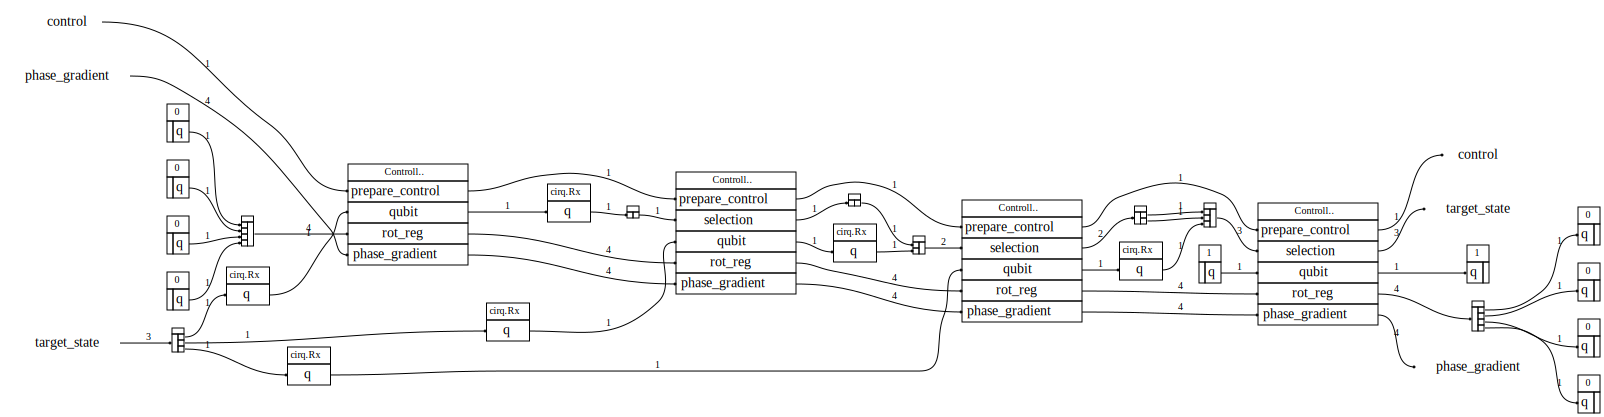

In [4]:
qsp = ControlledStatePreparationUsingRotations(
    n_qubits=n_qubits, rot_reg_size=rot_reg_size, state=tuple(state_coefs)
)
show_bloq(qsp)
show_bloq(qsp.decompose_bloq())

## Using the bloq in a circuit

Now let us show an example of this bloq being used to encode a state, together with the tensor contract to ensure that the coefficients are correctly encoded.

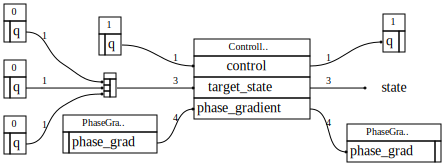

In [5]:
bb = BloqBuilder()
control = bb.add(OneState())
state = bb.join(np.array([bb.add(ZeroState()) for _ in range(n_qubits)]))
phase_gradient = bb.add(PhaseGradientState(rot_reg_size))
control, state, phase_gradient = bb.add(
    qsp, control=control, target_state=state, phase_gradient=phase_gradient
)
bb.add(OneEffect(), q=control)
bb.add(PhaseGradientState(bitsize=rot_reg_size, adjoint=True), phase_grad=phase_gradient)
circuit = bb.finalize(state=state)

show_bloq(circuit)
coefficients = circuit.tensor_contract()

And finally a comparison of the results obtained with the original state used.

In [9]:
accuracy = np.dot(coefficients, np.array(state_coefs).conj())

print(f"original state used: {tuple(state_coefs)}")
print(f"circuit result:      {tuple(coefficients)}\n")
print(f"accuracy: {abs(accuracy)}\n")

print("Comparison (coefficients in polar form):")
for i, (c, s) in enumerate(zip(coefficients, state_coefs)):
  print(f"  |{i:0{n_qubits}b}> result: {round(abs(c),4)} ∠{round(np.angle(c, deg=True),2)}º  exact: {round(abs(s),4)} ∠{round(np.angle(s, deg=True),2)}º")

original state used: ((0.3209885671412489+0.3852006469796078j), (-0.11931203515340516-0.011299378023046243j), (-0.11519176989551667-0.3180830888735431j), (-0.3732892621889186-0.3838169207753584j), (-0.11552249176669593+0.16389890395820558j), (-0.17670519747858485+0.35889255251075536j), (-0.22230220656686386+0.2716663039826279j), (0.0317505898887413-0.09301412166033653j))
circuit result:      ((0.25170871825786545+0.3767087182578651j), (-0.08838834764831838-0.01758153547950319j), (-0.07493202296122872-0.3767087182578652j), (-0.31935823077614-0.477953368534226j), (-0.12499999999999983+0.12499999999999999j), (-0.16332037060954688+0.3942902537373685j), (-0.16818638851795303+0.25170871825786534j), (0.011747606429224303-0.059059205739590837j))

accuracy: 0.9883051159344085

Comparison (coefficients in polar form):
  |000> result: 0.4531 ∠56.25º  exact: 0.5014 ∠50.2º
  |001> result: 0.0901 ∠-168.75º  exact: 0.1198 ∠-174.59º
  |010> result: 0.3841 ∠-101.25º  exact: 0.3383 ∠-109.91º
  |011> res